# Peaky Blinders IMDb Ratings, Part V

Putting it all together!

In [1]:
import pandas as pd
from requests import get
from bs4 import BeautifulSoup
import numpy as np
import locale
import seaborn as sns
import matplotlib.pyplot as plt

# Use IMDb search engine to find tconst for show, don't use read_csv of this data because can't put it online
title_basics_tsv = pd.read_csv('title.basics.tsv/data.tsv', sep='\t', 
                               # Was giving me a low_memory dtype warning
                               dtype={'startYear': str})

Enter a name of a Show: Peaky Blinders


C:\Users\Fani\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Fani\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Fani\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Fani\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is tr

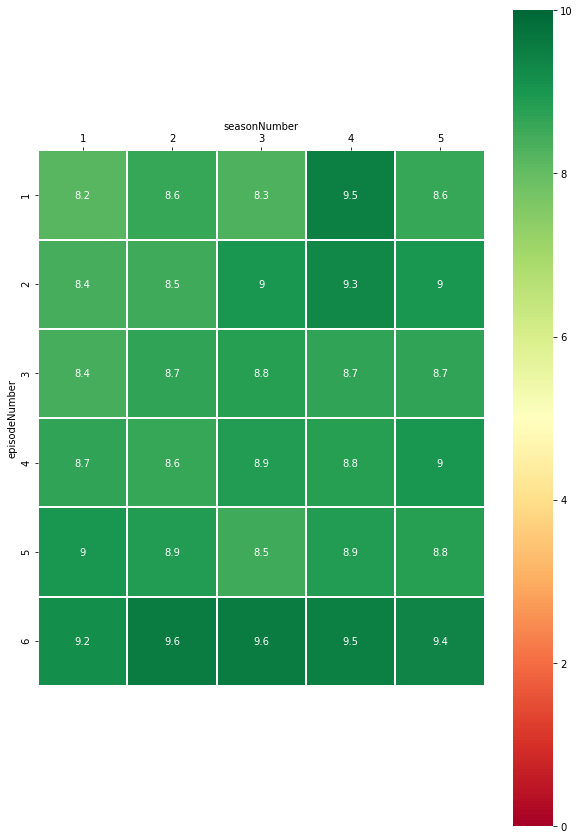

In [9]:
user_show_title = input("Enter a name of a Show: ") 
user_tconst = title_basics_tsv[title_basics_tsv.primaryTitle==user_show_title]
user_tconst = user_tconst.iloc[0]['tconst']
url = 'https://www.imdb.com/title/' + user_tconst
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')

seasons_URLs = html_soup.select('a[href*=season]')
numSeasons = len(seasons_URLs)

columns=['parentTconst','tconst','seasonNumber','episodeNumber','averageRating','numVotes']
show_info_df = pd.DataFrame(0, index=np.arange(numEpisodes*numSeasons), columns=columns)
show_info_df['averageRating'] = pd.to_numeric(show_info_df['averageRating'], downcast='float')

df_index = 0

for s in range(numSeasons):
    season_URL = 'https://www.imdb.com' + seasons_URLs[s]['href']
    response = get(season_URL)
    season_soup = BeautifulSoup(response.text, 'html.parser')
    numEpisodes = len(season_soup.find_all('input', attrs = {'name':'tconst'}))
    # print(season_URL)
    
    for e in range(0,numEpisodes,1):
        show_tconst = season_soup.find_all('input', attrs = {'name':'tconst'})[e]['value']
        no_season = numSeasons-s
        no_episode = e + 1    
        rating = float(season_soup.find_all('div', class_='ipl-rating-star small')[e].find('span', class_='ipl-rating-star__rating').text) 
        # num_votes = int(locale.atoi(season_soup.find_all('span', class_='ipl-rating-star__total-votes')[e].text.strip('()')))
        # print("{}\tSeason {}\tEp. {}\tRating {}\tVotes: {}".format(show_tconst, no_season, no_episode, rating, num_votes))
        
        show_info_df['parentTconst'][df_index] = user_tconst
        show_info_df['tconst'][df_index] = show_tconst
        show_info_df['seasonNumber'][df_index] = no_season
        show_info_df['episodeNumber'][df_index] = no_episode
        show_info_df['averageRating'][df_index] = rating
        # show_info_df['numVotes'][df_index] = num_votes
        df_index += 1

show_info_df = show_info_df[(show_info_df.T != 0).any()]
show_heatmap = show_info_df.pivot('episodeNumber', 'seasonNumber', 'averageRating')
plt.figure(figsize=(10,15))
show_plt = sns.heatmap(show_heatmap,
                        square=True,
                        linewidths=1,
                        annot=True,
                        cmap='RdYlGn',
                        vmin=0,
                        vmax=10)
show_plt.xaxis.set_ticks_position('top')
show_plt.xaxis.set_label_position('top')